A Fully-Convolutional Network using VGG weights for the encoder portion trained on the CityScape dataset to distinguish pixels into the following categories: road, sidewalk, pedestrian, vehicle (including bicycles), background.

# Import and Setup

In [119]:
#import modules
import cv2
import os
import random
import numpy as np
from scipy import misc
import sys
from random import shuffle
from random import uniform
import zipfile
from collections import OrderedDict
import glob
import time
from PIL import Image, ImageFilter 
from scipy.signal import convolve2d
from scipy.ndimage.filters import maximum_filter
import scipy.ndimage as ndimage
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
#Database location on Disk
gt_dir = r'C:\Users\RENT\Desktop\Mobilye project\CityScapes\gtFine'
imgs_dir = r'C:\Users\RENT\Desktop\Mobilye project\CityScapes\leftImg8bit'

# Import data
gt_train_path = os.path.join(gt_dir, 'train')
imgs_train_path = os.path.join(imgs_dir, 'train')
gt_val_path = os.path.join(gt_dir, 'val')
imgs_val_path = os.path.join(imgs_dir, 'val')
gt_test_path = os.path.join(gt_dir, 'test')
imgs_test_path = os.path.join(imgs_dir, 'test')
# Get training data filenames
def get_files(imgs_dir, gt_dir):
    
    cities = os.listdir(imgs_dir)
    gt = []
    imgs = []
    for city in cities:
        new_gt_path = os.path.join(gt_dir, city)
        new_imgs_path = os.path.join(imgs_dir, city)
        gt += glob.glob(os.path.join(new_gt_path, "*labelIds.png"))
        imgs += glob.glob(os.path.join(new_imgs_path, "*.png"))
    imgs.sort()
    gt.sort()
    return imgs, gt

train_imgs, train_gt = get_files(imgs_train_path, gt_train_path)
print(len(train_imgs))
val_imgs, val_gt = get_files(imgs_val_path, gt_val_path)
test_imgs, test_gt = get_files(imgs_test_path, gt_test_path)

2975


# Utility Functions

In [3]:
#Marking only traffic lights data
def prepare_ground_truth(img):
    new_image = np.zeros((img.shape[0], img.shape[1], 3))
    new_image[img == 19,:] = [0,255,0]
    return new_image.astype(np.float32)
    

In [4]:
#Generate batch for training
def data_generator(batch_size=1, num_classes=1, mode='train', imgs=train_imgs, gt=train_gt, im_size=500):
    
    # Expects sorted lists of training images and ground truth as
    # 'data' and 'labels'
    if (mode == 'val'):
        imgs = val_imgs
        gt = val_gt
    elif (mode == 'test'):
        imgs = test_imgs
        gt = test_gt
    
    # get shape from any image
    shape_im = misc.imread(random.choice(imgs))
        
    # Shuffle dataset
    combined = list(zip(imgs, gt))
    shuffle(combined)
    imgs[:], gt[:] = zip(*combined)
        
    while(True):
        for i in range(0,len(imgs),batch_size):
            images = np.empty((batch_size, im_size, im_size, shape_im.shape[2]))
            labels = np.empty((batch_size, im_size, im_size, 3))
            for j, img in enumerate(imgs[i:i+batch_size]):
                # Crop the size we want from a random spot in the image (as a form of
                # minor data augmentation)
                new_start_row = np.random.randint(0, shape_im.shape[0] - im_size)
                new_start_col = np.random.randint(0, shape_im.shape[1] - im_size)
                train_im = misc.imread(img).astype(np.float32)
                
                train_im = train_im[new_start_row:new_start_row+im_size, new_start_col:new_start_col+im_size]
                images[j,:,:,:] = train_im
                
                gt_im = misc.imread(gt[i+j])
                gt_im = gt_im[new_start_row:new_start_row+im_size, new_start_col:new_start_col+im_size]
                labels[j,:,:,:] = prepare_ground_truth(gt_im)
            
            yield(images,labels)
            

In [5]:
#Example for visualization
def visualize_prediction(ims, gts):
    
    fig = plt.figure(figsize=(20,20))
    for i, im in enumerate(ims):
        a=fig.add_subplot(5,2,i+1)
        new_image = Image.blend(Image.fromarray(im.astype(np.uint8), mode='RGB').convert('RGBA'),
                            Image.fromarray(gts[i].astype(np.uint8), mode='RGB').convert('RGBA'),
                            alpha=0.5)
        plt.imshow(new_image)
    plt.show()

In [6]:
# Show generated data

In [237]:
dat_gen = data_generator(batch_size=10, im_size=1000)

In [238]:
ims, gts = dat_gen.__next__()

c:\users\rent\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
c:\users\rent\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
c:\users\rent\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


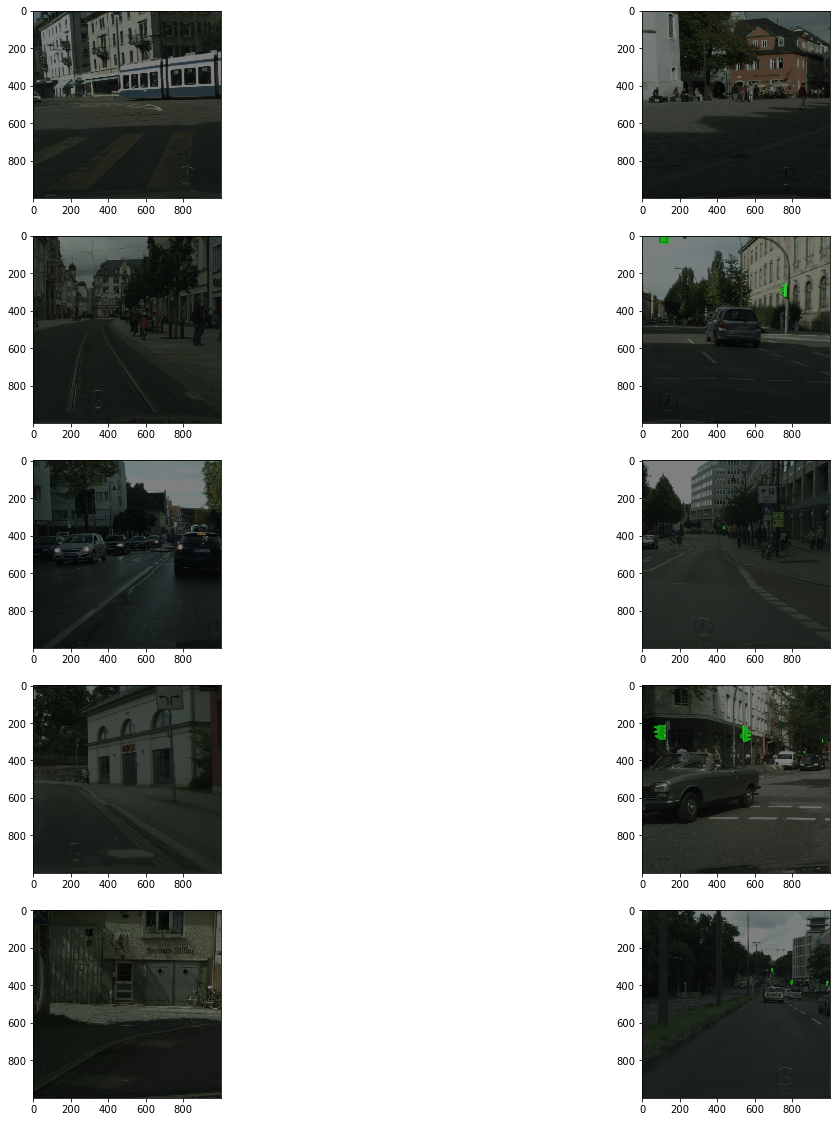

In [242]:
visualize_prediction(ims, gts)




In [249]:
def findcandidat(img,c,org):
    kernel = np.ones((7,7),np.float32)/(-49)
    kernel[1,1]=48/49
    #dst = cv2.filter2D(img,-1,kernel)
    kernel2 = np.ones((3,3),np.float32)/(9)
    lowpass = convolve2d(img,kernel2,'same')
    high = convolve2d(img,kernel,'same')
    
    dst = scipy.ndimage.maximum_filter(high, 20) 
    plt.subplot(121),plt.imshow(img*255,c),plt.title('Original')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(dst**2,cmap=c),plt.title('Averaging')
    plt.xticks([]), plt.yticks([])
    plt.colorbar();
    plt.show()
    mask = dst**2 > 6000
    mask3 =np.stack((np.zeros(np.shape(mask),dtype=bool),mask,np.zeros(np.shape(mask),dtype=bool)),axis=2)
    org[mask3]=255
    res = 255*mask
    
    plt.imshow(res)
    plt.colorbar();
    plt.show()
    return org
    


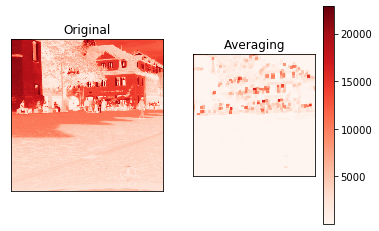

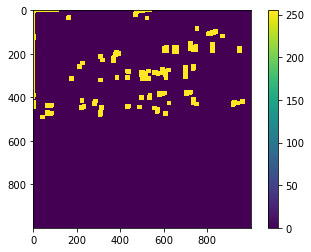

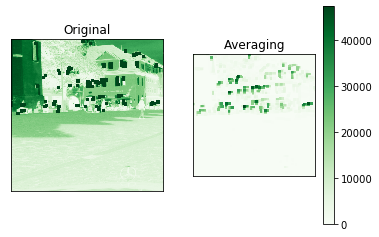

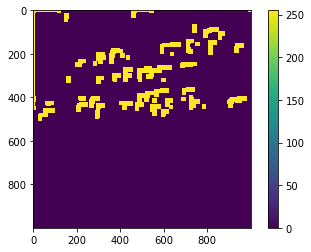

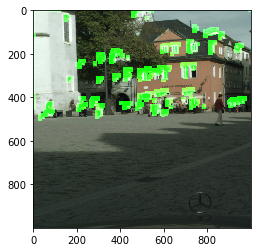

In [254]:


#imgex=np.zeros((img.shape[0],img.shape[1],5))
#imgex[:,:,0:3] = np.copy(img)

for i, c in enumerate(( 'Reds','Greens')):
    img = ims[1,:,:,:]
    mask = findcandidat(img[:,:,i],c,img)

plt.imshow(mask/255)
    

In [240]:
import scipy

In [253]:
train_imgs


['C:\\Users\\RENT\\Desktop\\Mobilye project\\CityScapes\\leftImg8bit\\train\\zurich\\zurich_000082_000019_leftImg8bit.png',
 'C:\\Users\\RENT\\Desktop\\Mobilye project\\CityScapes\\leftImg8bit\\train\\weimar\\weimar_000090_000019_leftImg8bit.png',
 'C:\\Users\\RENT\\Desktop\\Mobilye project\\CityScapes\\leftImg8bit\\train\\erfurt\\erfurt_000067_000019_leftImg8bit.png',
 'C:\\Users\\RENT\\Desktop\\Mobilye project\\CityScapes\\leftImg8bit\\train\\weimar\\weimar_000112_000019_leftImg8bit.png',
 'C:\\Users\\RENT\\Desktop\\Mobilye project\\CityScapes\\leftImg8bit\\train\\darmstadt\\darmstadt_000023_000019_leftImg8bit.png',
 'C:\\Users\\RENT\\Desktop\\Mobilye project\\CityScapes\\leftImg8bit\\train\\jena\\jena_000076_000019_leftImg8bit.png',
 'C:\\Users\\RENT\\Desktop\\Mobilye project\\CityScapes\\leftImg8bit\\train\\erfurt\\erfurt_000034_000019_leftImg8bit.png',
 'C:\\Users\\RENT\\Desktop\\Mobilye project\\CityScapes\\leftImg8bit\\train\\hamburg\\hamburg_000000_085982_leftImg8bit.png',
 'C: